In [1]:
%matplotlib inline
import random
from mxnet import autograd, gluon, init, np, npx
from d2l import mxnet as d2l
from mxnet.gluon import nn

npx.set_np()

# Exercises week 5
## 8.1.5.1



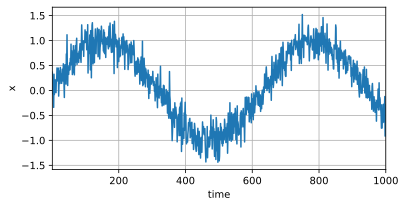

In [4]:
T = 1000  # Generate a total of 1000 points
time = np.arange(1, T + 1, dtype=np.float32)
x = np.sin(0.01 * time) + np.random.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [35]:
tau = 10
features = np.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# Only the first `n_train` examples are used for training
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [36]:
# A simple MLP
def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(10, activation='relu'), nn.Dense(1))
    net.initialize(init.Xavier())
    return net

# Square loss
loss = gluon.loss.L2Loss()

In [37]:
def train(net, train_iter, loss, epochs, lr):
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': lr})
    for epoch in range(epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.045112
epoch 2, loss: 0.035917
epoch 3, loss: 0.034261
epoch 4, loss: 0.030759
epoch 5, loss: 0.028398


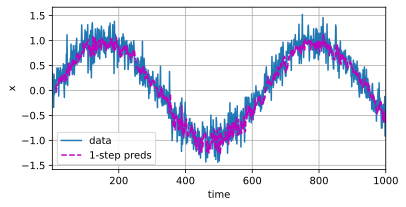

In [38]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.asnumpy(), onestep_preds.asnumpy()], 'time', 'x',
         legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

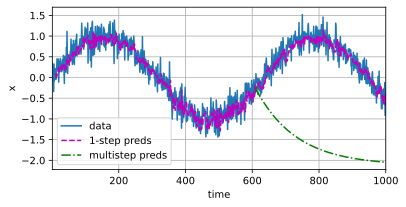

In [39]:
multistep_preds = np.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]], [
    x.asnumpy(),
    onestep_preds.asnumpy(), multistep_preds[n_train + tau:].asnumpy()],
         'time', 'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

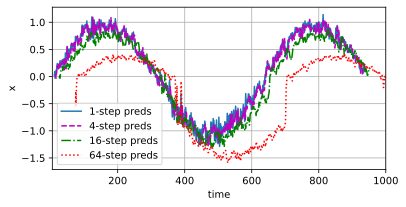

In [40]:
max_steps = 64

features = np.zeros((T - tau - max_steps + 1, tau + max_steps))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i:i + T - tau - max_steps + 1]

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1:T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].asnumpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds'
                 for i in steps], xlim=[5, 1000], figsize=(6, 3))

### 1.

If we change the number of past observations used, we can get better results in the multi-step predictors. In the below figure, it can be seen that just increasing $\tau$ by just 1, to 5, is enough to make the 64-step predictions fit the data a lot closer. The improvement by increasing $\tau$ to 8 and even 10 is minimal.

![tausteps](./images/s8_tau_various.jpg)

### 2.

For this model, the data used fits the sin or cos function. For simplicity, we will assume that it is sin. We know that $\frac{d}{dx} \sin (x) = \cos (x)$. At each point of the data, we can use this to compute the gradient, which we can use to make the prediction. This prediction needs to be within the margin of error $\epsilon$. This means we need to minimise the loss after computing the prediction: $l(w,b) = \frac{1}{2}(y^i - y^i) ^ 2$

### 3.

We could add a new feature which summarises all older features (by using the mean, for example) that are not included in the window $t - \tau$, this keeps the number of features constant, while also using older observations. This would improve performance, because using more observations makes that predications are more informed. 

### 4.

This question makes absolutely no sense. What is meant by 'architecture'? Initalisation? The type of network used? Training? The types of blocks added?

## 8.4.6.3

If we sum the gradient at every step (which is implied by the chain rule), we will see that, the gradient will approach zero. This becomes a problem if the network is very deep (the backpropagation is deep), and the gradient values become smaller and smaller. Since RNNs are usually quite deep (sentences are long, for example), this can become a problem quickly.

## 8.5.8.4

In [53]:
import math

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [46]:
X = np.arange(10).reshape((2, 5))

In [44]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return np.random.normal(scale=0.01, size=shape, ctx=device)

    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = np.zeros(num_hiddens, ctx=device)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = np.zeros(num_outputs, ctx=device)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.attach_grad()
    return params

In [49]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (np.zeros((batch_size, num_hiddens), ctx=device),)

def rnn(inputs, state, params):
    # Shape of `inputs`: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        H = np.tanh(np.dot(X, W_xh) + np.dot(H, W_hh) + b_h)
        Y = np.dot(H, W_hq) + b_q
        outputs.append(Y)
    return np.concatenate(outputs, axis=0), (H,)

class RNNModelScratch:  #@save
    """An RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens, device, get_params,
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = npx.one_hot(X.T, self.vocab_size)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, ctx):
        return self.init_state(batch_size, self.num_hiddens, ctx)
    
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.as_in_context(d2l.try_gpu()), state)

def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, ctx=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: np.array([outputs[-1]], ctx=device).reshape((1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(axis=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

'time traveller wyhjiixmk '

In [56]:
def grad_clipping(net, theta):  #@save
    """Clip the gradient."""
    if isinstance(net, gluon.Block):
        params = [p.data() for p in net.collect_params().values()]
    else:
        params = net.params
    norm = math.sqrt(sum((p.grad**2).sum() for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """Train a model within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], ctx=device)
        else:
            for s in state:
                s.detach()
        y = Y.T.reshape(-1)
        X, y = X.as_in_ctx(device), y.as_in_ctx(device)
        with autograd.record():
            y_hat, state = net(X, state)
            l = loss(y_hat, y).mean()
        l.backward()
        #grad_clipping(net, 1)
        updater(batch_size=1)  # Since the `mean` function has been invoked
        metric.add(l * y.size, y.size)
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

def train_ch8(net, train_iter, vocab, lr, num_epochs, device,  #@save
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # Initialize
    if isinstance(net, gluon.Block):
        net.initialize(ctx=device, force_reinit=True, init=init.Normal(0.01))
        trainer = gluon.Trainer(net.collect_params(), 'sgd',
                                {'learning_rate': lr})
        updater = lambda batch_size: trainer.step(batch_size)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device,
                                     use_random_iter)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

perplexity 1.5, 16013.7 tokens/sec on gpu(0)
time traveller held in his hand was a glitteringmetallic framewo
travellerit s against reason said filbywhat said a very you


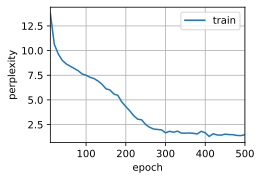

In [55]:
# Output of this cell is with gradient clipping

num_epochs, lr = 500, 1

net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

perplexity 2068494915426200832.0, 13413.2 tokens/sec on gpu(0)
time travellercmhgcmhgcmhgcmhgcmhgcmhgcmhgcmhgcmhgcmhgcmhgcmhgcm
travellergcmhgcmhgcmhgcmhgcmhgcmhgcmhgcmhgcmhgcmhgcmhgcmhgc


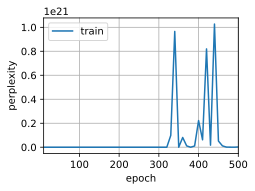

In [57]:
# Output of this cell is without gradient clipping

num_epochs, lr = 500, 1

net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

With gradient clipping, we see that in the first few epochs, the perplexity goes down (as it should, because the model is become more accurate while being trained). In later epochs, however, the perplexity becomes extremely high, which is also reflected in the final generated sentence. This is clearly the exploding or vanishing gradient problem in action.

## 9.1.5.3

perplexity 1.1, 51200.8 tokens/sec on gpu(0)
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


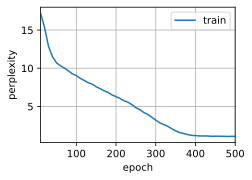

In [61]:
from mxnet.gluon import rnn

batch_size, num_steps = 32, 35
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1

gru_layer = rnn.GRU(num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

perplexity 1.2, 80720.3 tokens/sec on gpu(0)
time travellerit s against reason said filby but you are wrong t
travelleryou can show black is white by argument said filby


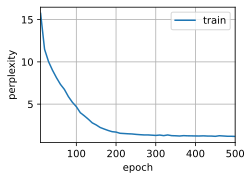

In [62]:
gru_layer = rnn.RNN(num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

As can be seen, the perplexity of the RNN is marginally higher, though its runtime is considerably faster. We also see that the RNN drops its perplexity more quickly in the first epochs, and then remains more or less constant, whereas the GRU decreases its perplexity more evenly. The output string is identical in the second half, but neither output makes much sense. As for short term dependencies, these are not really present here. Both sentences are somewhat syntactically correct. It might be that the example is too simple to see a big difference between RNNs and GRUs.